In [7]:
import time

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from utils import read_raw, read_rgb, read_data, read_envi_ascii
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from machine_learning import DecisionTree, svm_classifier, RandomForest, AdaBoost, GradientBoosting, XGBoost, MLP, predict
import cv2

In [8]:
# Read data
data = read_envi_ascii('data/1.txt')

huangqi = data['huangqi'][:, :110]
zazhi1 = data['zazhi1'][:, :110]
# zazhi2 = data['zazhi2']
beijing = data['beijing'][:, :110]
gancaopian = data['gancaopian'][:, :110]
# hongqi = data['hongqi']
huangqi_y = np.ones(huangqi.shape[0]) * 3
zazhi1_y = np.ones(zazhi1.shape[0]) * 1
# zazhi2_y = np.ones(zazhi2.shape[0]) * 2
beijing_y = np.ones(beijing.shape[0]) * 0
gancaopian_y = np.ones(gancaopian.shape[0]) * 4
# hongqi_y = np.ones(hongqi.shape[0]) * 5
data_x = np.concatenate((huangqi, zazhi1,  beijing, gancaopian), axis=0)
data_y = np.concatenate((huangqi_y, zazhi1_y, beijing_y, gancaopian_y), axis=0)

In [9]:
t1 = time.time()

In [10]:


select = SelectKBest(chi2, k=10)

x_new = select.fit_transform(data_x, data_y)

selected_features = select.get_support(indices=True)
print(selected_features)


[ 91  92  93  94  95  96  97  98  99 100]


In [11]:
from sklearn.model_selection import train_test_split
data_x = data_x[:, selected_features]
train_x, test_x, train_y, test_y = train_test_split(data_x ,data_y, test_size=0.3, stratify=data_y)

In [12]:
file_name = 'models/dt.p'
DecisionTree(train_x, train_y,test_x, test_y, file_name)

预测时间： 0.0
DT训练模型评分：1.0
DT待测模型评分：0.9593220338983051
DT预测结果：[4. 1. 3. ... 4. 1. 3.]
---------------------------------------------------------------------------------------------------
DT分类报告：              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       369
         1.0       1.00      1.00      1.00       343
         3.0       0.91      0.92      0.92       360
         4.0       0.93      0.92      0.93       403

    accuracy                           0.96      1475
   macro avg       0.96      0.96      0.96      1475
weighted avg       0.96      0.96      0.96      1475

DT混淆矩阵：[[369   0   0   0]
 [  0 343   0   0]
 [  0   0 331  29]
 [  0   0  31 372]]


In [13]:
data_x = read_raw('data/01newrawfile_ref.raw', shape=(750, 288, 384), setect_bands=selected_features)

In [14]:
data_x_shape = data_x.shape
data_x = data_x.reshape(-1, data_x.shape[2])
data_y = predict(data_x, file_name)

预测时间： 0.01994633674621582


In [15]:
data_y = data_y.reshape(data_x_shape[0], data_x_shape[1]).astype(np.uint8)

6.736057281494141


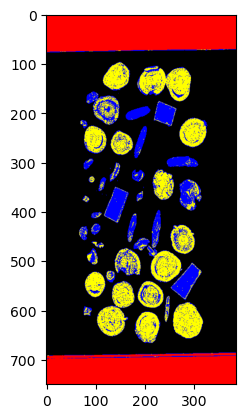

In [16]:
pre_data_y = np.zeros((data_y.shape[0], data_y.shape[1], 3), dtype=np.uint8)

pre_data_y[data_y == 0] = [0, 0, 0]#黑色
pre_data_y[data_y == 1] = [255, 0, 0]#红色
pre_data_y[data_y == 2] = [0, 255, 0]#绿色
pre_data_y[data_y == 3] = [0, 0, 255]#蓝色
pre_data_y[data_y == 4] = [255, 255, 0]#黄色
pre_data_y[data_y == 5] = [255, 0, 255]#紫色


print(time.time()-t1)

plt.imshow(pre_data_y)
plt.savefig('01newrawfile_ref.png', dpi=300)

In [17]:
# 连通域分析
from scipy import ndimage
labels, num_features = ndimage.label(data_y)
for i in range(1, num_features + 1):
    mask = (labels == i)
    counts = np.bincount(data_y[mask])
    # 如果2的个数在所有的像素点中占比超过25%，则认为是2，否则认为0和1中最多的是哪个就是哪个
    # 如果有count[2]，才进入判断，否则直接认为是0或者1
    # if len(counts) > 2 and counts[2] / np.sum(counts) > 0.20:
    #     data_y[mask] = 2
    # else:
    #     data_y[mask] = np.argmax(counts)
    data_y[mask] = np.argmax(counts)


10.760062456130981


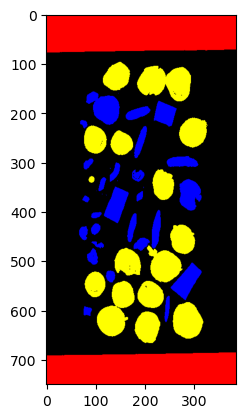

In [18]:
pre_data_y = np.zeros((data_y.shape[0], data_y.shape[1], 3), dtype=np.uint8)

pre_data_y[data_y == 0] = [0, 0, 0]
pre_data_y[data_y == 1] = [255, 0, 0]
pre_data_y[data_y == 2] = [0, 255, 0]
pre_data_y[data_y == 3] = [0, 0, 255]
pre_data_y[data_y == 4] = [255, 255, 0]
pre_data_y[data_y == 5] = [255, 0, 255]



print(time.time()-t1)

plt.imshow(pre_data_y)
plt.savefig('01result.png', dpi=300)